In [1]:
!pip install geopandas
import geopandas as gpd
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

In [2]:
# Load the Shapefile
states_path = "/kaggle/input/india-gis-data/India States"
india_states = gpd.read_file(states_path)

In [3]:
# Reproject to a Projected CRS (for proper area/perimeter)
india_states = india_states.to_crs(epsg=32644)  # UTM Zone 44N (meters)

In [4]:
# Feature Engineering
india_states["area_km2"] = india_states.geometry.area / 1e6
india_states["perimeter_km"] = india_states.geometry.length / 1e3
india_states["compactness"] = (india_states["perimeter_km"] ** 2) / (4 * 3.1416 * india_states["area_km2"])

In [5]:
# Generate Mobility Labels (Heuristic)
def classify_terrain(row):
    if row["area_km2"] > 200000 or row["compactness"] > 30:
        return "Difficult"
    elif row["area_km2"] > 80000 or row["compactness"] > 20:
        return "Moderate"
    else:
        return "Easy"
india_states["mobility_class"] = india_states.apply(classify_terrain, axis=1)

In [6]:
# Train Classifier
X = india_states[["area_km2", "perimeter_km", "compactness"]]
y = india_states["mobility_class"]
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state=42)

model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

In [7]:
# Classification Report
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

   Difficult       0.50      0.50      0.50         2
        Easy       1.00      1.00      1.00         4
    Moderate       0.67      0.67      0.67         3

    accuracy                           0.78         9
   macro avg       0.72      0.72      0.72         9
weighted avg       0.78      0.78      0.78         9



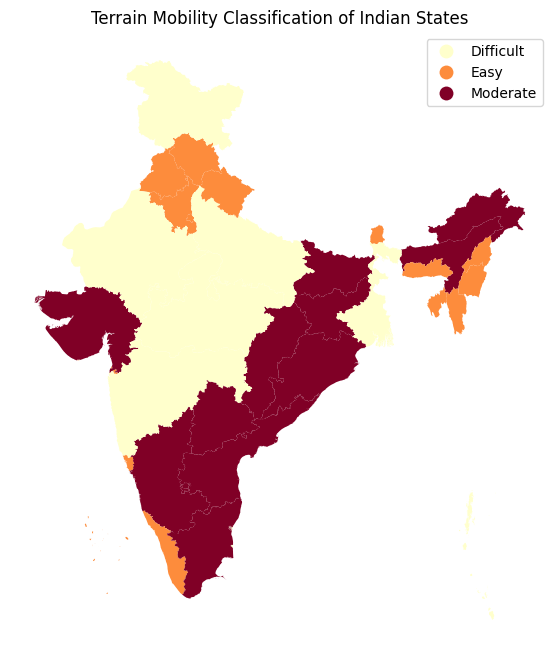

In [8]:
# Visualize Classified Terrain
fig, ax = plt.subplots(1, 1, figsize=(12, 8))
india_states.plot(column="mobility_class", cmap="YlOrRd", legend=True, ax=ax)
ax.set_title("Terrain Mobility Classification of Indian States")
ax.axis("off")
plt.show()

In [9]:
# Show data table
india_states[["st_nm", "area_km2", "perimeter_km", "compactness", "mobility_class"]].head()

,st_nm,area_km2,perimeter_km,compactness,mobility_class
0,Andaman & Nicobar Island,7817.854418,3557.418732,128.816506,Difficult
1,Arunanchal Pradesh,85847.950600,2616.734076,6.347144,Moderate
2,Assam,81210.148144,3004.427604,8.845091,Moderate
3,Bihar,94563.826622,2742.086443,6.327416,Moderate
4,Chandigarh,118.695624,52.694985,1.861628,Easy


In [10]:
india_states[["st_nm", "area_km2", "perimeter_km", "compactness", "mobility_class"]].to_csv("terrain_mobility_classification.csv", index=False)